<a href="https://colab.research.google.com/github/dunkelweizen/AB-Demo/blob/master/Working_Project_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

I had to run my model locally because it was taking too long in Colab. My initial models were giving me a validation accuracy of around 21-22% which isn't great but is better than baseline. With XGBoost, I got a validation accuracy of around 31%. 
Since I'm using leave-one-out-cross-validation instead of a train/test/validation split, I had to fit permutation importance to my training set, which shows how important different features are to that set but does not generalize to other sets of data. 

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

In [0]:
# -*- coding: utf-8 -*-
"""
Created on Wed Dec  4 21:11:16 2019

@author: caino
"""
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

#%%explore and clean data


df = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/thanksgiving-2015/thanksgiving-2015-poll-data.csv')



df.columns = ['ID', 'Celebrate', 'Main_Dish', 'Main_Dish_Other', 'Main_Dish_Cooked', 'Main_Dish_Cooked_Other', 'Stuffing',
              'Stuffing_Other', 'Cranberry_Sauce', 'Cranberry_Sauce_Other', 'Gravy', 'Brussel_Sprouts', 'Carrots', 'Cauliflower',
              'Corn', 'Cornbread', 'Fruit_Salad', 'Green_Beans', 'Mac_and_Cheese', 'Mashed_Potatoes', 'Rolls_Biscuits', 'Squash',
              'Salad', 'Sweet_Potatoes', 'Side_Dish_Other1', 'Side_Dish_Other2', 'Apple_Pie', 'Buttermilk_Pie', 'Cherry_Pie', 
              'Chocolate_Pie', 'Coconut_Cream_Pie', 'Key_Lime_Pie', 'Peach_Pie', 'Pecan_Pie', 'Pumpkin_Pie', 'Sweet_Potato_Pie', 
              'No_Pie', 'Other_Pie1', 'Other_Pie2', 'Apple_Cobbler', 'Blondies', 'Brownies', 'Carrot_Cake', 'Cheesecake', 'Cookies',
              'Fudge', 'Ice_Cream', 'Peach_Cobbler', 'No_Dessert', 'Other_Dessert1', 'Other_Dessert2', 'Prayer', 'Travel_Distance', 'Parade',
              'Kids_Table_Age', 'Old_Friends', 'Friendsgiving', 'Black_Friday_Shopper', 'Retail_Worker', 'Black_Friday_Worker', 'Neighborhood_Type',
              'Age', 'Gender', 'Household_Earnings', 'US_Region']




side_dishes = ['Stuffing',
              'Stuffing_Other', 'Cranberry_Sauce', 'Cranberry_Sauce_Other', 'Gravy', 'Brussel_Sprouts', 'Carrots', 'Cauliflower',
              'Corn', 'Cornbread', 'Fruit_Salad', 'Green_Beans', 'Mac_and_Cheese', 'Mashed_Potatoes', 'Rolls_Biscuits', 'Squash',
              'Salad', 'Sweet_Potatoes', 'Side_Dish_Other1', 'Side_Dish_Other2', 'Apple_Pie', 'Buttermilk_Pie', 'Cherry_Pie', 
              'Chocolate_Pie', 'Coconut_Cream_Pie', 'Key_Lime_Pie', 'Peach_Pie', 'Pecan_Pie', 'Pumpkin_Pie', 'Sweet_Potato_Pie', 
              'No_Pie', 'Other_Pie1', 'Other_Pie2', 'Apple_Cobbler', 'Blondies', 'Brownies', 'Carrot_Cake', 'Cheesecake', 'Cookies',
              'Fudge', 'Ice_Cream', 'Peach_Cobbler', 'No_Dessert', 'Other_Dessert1', 'Other_Dessert2']
#get rid of any rows where they don't celebrate
df = df.drop(df[df.Celebrate == 'No'].index)
df = df.drop('Celebrate', axis = 1)
#remove any rows where no US_Region is given



#%%



In [42]:
df['US_Region'].isnull().sum()

49

In [0]:
df['US_Region'] = df['US_Region'].dropna()

In [57]:
df['US_Region'].isnull().sum()

49

In [59]:
df['US_Region'].isnull().sum()

0

In [39]:
df['Main_Dish'].value_counts(normalize=True)

Turkey                    0.881930
Other (please specify)    0.035934
Ham/Pork                  0.029774
Tofurkey                  0.020534
Chicken                   0.012320
Roast beef                0.011294
I don't know              0.005133
Turducken                 0.003080
Name: Main_Dish, dtype: float64

In [0]:
 

#%% create data wrangling function

def wrangle(df):
    df = df.dropna(subset=['US_Region'])
    #remove earnings, is creating a map of earning potential rather than anything to do with food
    df = df.drop('Household_Earnings', axis=1)
    #Simplifying the regions in order to increase model accuracy
    df['US_Region'] = df['US_Region'].apply(lambda x : 'Pacific' if ((x == 'Pacific') | (x == 'Mountain')) else x)
    df['US_Region'] = df['US_Region'].apply(lambda x : 'Northeast' if ((x == 'New England') | (x == 'Middle Atlantic')) else x)
    df['US_Region'] = df['US_Region'].apply(lambda x : 'Midwest' if ((x == 'East South Central') | (x == 'East North Central')) else x)

    #data is formatted so that a column has the name of the dish if true and NaN if false
#so replace all the NaN with No and all values with Yes
#also for Parade column
    for column in df.columns:
        if column in side_dishes:
            df[column] = df[column].fillna('No')
        elif column == 'Parade':
            df[column] = df[column].fillna('No')
#removing the 'Other' side dish columns for simplicities' sake
    df = df.replace('nan', np.NaN)
    for column in df.columns:
        if 'Other' in column:
          df = df.drop(column, axis=1)
#simplify main dish options
    main_dishes = ('Turkey', 'Ham/Pork', 'Tofurkey', 'Chicken')
    df['Main_Dish'] = df['Main_Dish'].apply(lambda x : x if x in main_dishes else 'Other')
#remove the ID column, it's meaningless
    df = df.drop('ID', axis=1)
#replace empty values in Black_Friday_Worker with 'No' if person isn't in retail      
    for i in range(len(df)):
        if df['Retail_Worker'].iloc[i] == 'No':
            df['Black_Friday_Worker'].iloc[i] = 'No'
#fix NaN values in other columns
    df['Kids_Table_Age'] = df['Kids_Table_Age'].fillna('No Kids Table')
    mode = df['Age'].mode()[0]
    df['Age'] = df['Age'].fillna(mode)
    mode = df['Travel_Distance'].mode()[0]
    df['Travel_Distance'] = df['Travel_Distance'].fillna(mode)
    df['Neighborhood_Type'] = df['Neighborhood_Type'].fillna('Other')
    df['Main_Dish'] = df['Main_Dish'].fillna("I don't know")
    df['Main_Dish_Cooked'] = df['Main_Dish_Cooked'].fillna("I don't know")
    df = df.fillna('No')
    return df

In [0]:
#%%splitting data

train, test = train_test_split(df)
train = wrangle(train)
test = wrangle(test)


In [0]:

#%% creating X and y
def X_y_dataframes(train, test, target):
    X_train = train.drop(target, axis=1)
    X_test = test.drop(target, axis=1)
    y_train = train[target]
    y_test = test[target]
    #ordinal encoding
    encoder = OrdinalEncoder()
    X_train_encoded = encoder.fit_transform(X_train)
    X_test_encoded = encoder.fit_transform(X_test)
    #converting encoded arrays back to dataframes
    X_train_encoded = pd.DataFrame(X_train_encoded)
    X_train_encoded.columns = X_train.columns
    X_test_encoded = pd.DataFrame(X_test_encoded)
    X_test_encoded.columns = X_test.columns
    return X_train_encoded, X_test_encoded, y_train, y_test

In [0]:

#%% leave one out validation
def loocv(X_train_encoded, y_train, model):
    num_folds = 10
    num_instances = len(X_train_encoded)
    loocv = LeaveOneOut()
    results = cross_val_score(model, X_train_encoded, y_train, cv=loocv)
    print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))


In [49]:

#%%
target = 'US_Region'
X_train_encoded, X_test_encoded, y_train, y_test = X_y_dataframes(train, test, target)
#%%Baseline model
print(y_train.value_counts(normalize=True))
baseline = 'South Atlantic'

South Atlantic        0.222222
Northeast             0.207977
Midwest               0.202279
Pacific               0.192308
West South Central    0.094017
West North Central    0.081197
Name: US_Region, dtype: float64


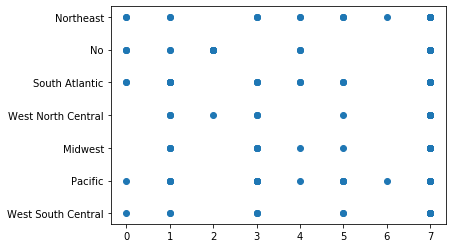

In [0]:
import matplotlib.pyplot as plt
plt.scatter(x=X_train_encoded['Main_Dish'], y=y_train)
plt.show()

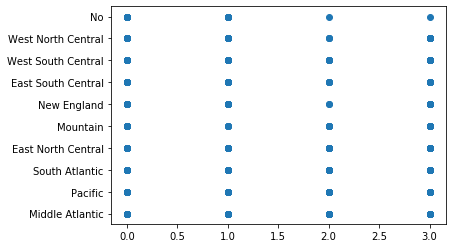

In [0]:
plt.scatter(x=X_train_encoded['Travel_Distance'], y=y_train)
plt.show()

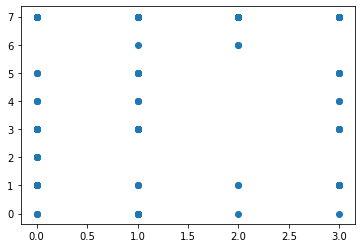

In [0]:
plt.scatter(x=X_train_encoded['Travel_Distance'], y=X_train_encoded['Main_Dish'])
plt.show()

In [0]:
#%% Logistic Regression Model

model = LogisticRegression(solver='lbfgs', max_iter = 10000, multi_class='auto')
model.fit(X_train_encoded, y_train)
loocv(X_train_encoded, y_train, model)
#26.6% accurate


Accuracy: 27.755% (44.779%)


In [0]:
def select_features(X_train_encoded, y_train, num_features):
    classifier = RandomForestClassifier(n_estimators=100)
    rfe_selector = RFE(estimator=classifier, n_features_to_select=num_features, step=10, verbose=5)
    rfe_selector.fit(X_train_encoded, y_train)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X_train_encoded.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'selected features')
    print(rfe_feature)
    return rfe_feature

In [0]:
#%% Random Forest Model

classifier = RandomForestClassifier()
features = select_features(X_train_encoded, y_train, 10)
X_train_encoded = X_train_encoded[features]
classifier.fit(X_train_encoded, y_train)
loocv(X_train_encoded, y_train, classifier)
#22.2% accurate


Fitting estimator with 62 features.
Fitting estimator with 52 features.
Fitting estimator with 42 features.
Fitting estimator with 32 features.
Fitting estimator with 22 features.
Fitting estimator with 12 features.
10 selected features
['Main_Dish_Cooked', 'Cranberry_Sauce', 'Corn', 'Sweet_Potatoes', 'Travel_Distance', 'Kids_Table_Age', 'Neighborhood_Type', 'Age', 'Gender', 'Household_Earnings']


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 19.048% (39.268%)


In [0]:
#%% those were terrible, do better! Randomized Search for hyperparameters


clf = RandomForestClassifier()
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(results['mean_test_score'][candidate], results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
#%%
# specify parameters and distributions to sample from
param_dist = {'max_depth': range(10, 50, 2),
              'min_samples_leaf': [1,2,3,4,5],'min_samples_split': [2, 3, 4, 5],
              'n_estimators': range(100, 500, 10),
              "criterion": ["gini", "entropy"]}

n_iter_search = 25
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False, n_jobs=-1)

random_search.fit(X_train_encoded, y_train)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.240 (std: 0.016)
Parameters: {'n_estimators': 330, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 46, 'criterion': 'entropy'}

Model with rank: 2
Mean validation score: 0.239 (std: 0.007)
Parameters: {'n_estimators': 430, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_depth': 44, 'criterion': 'gini'}

Model with rank: 3
Mean validation score: 0.238 (std: 0.018)
Parameters: {'n_estimators': 140, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_depth': 26, 'criterion': 'gini'}



In [0]:
#%% Grid Search for hyperparameters

param_grid = {"max_depth": range(30, 50, 5),
              "n_estimators": range(100, 500, 10),
              "min_samples_leaf": range(2, 5)
              }

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=3, iid=False, n_jobs=-1)
grid_search.fit(X_train_encoded, y_train)
report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: 0.238 (std: 0.015)
Parameters: {'max_depth': 30, 'min_samples_leaf': 4, 'n_estimators': 230}

Model with rank: 2
Mean validation score: 0.235 (std: 0.007)
Parameters: {'max_depth': 30, 'min_samples_leaf': 4, 'n_estimators': 400}

Model with rank: 3
Mean validation score: 0.235 (std: 0.017)
Parameters: {'max_depth': 40, 'min_samples_leaf': 3, 'n_estimators': 300}



In [0]:
#%% this model is awful, let's try a new target
#predict whether someone will have Turkey, Ham, or something else based on other items?

train['Main_Dish'].unique()
train['Main_Dish'].value_counts(normalize=True)

#baseline = Turkey, 86.7%
#%%
target = 'Main_Dish'
X_train_encoded, X_test_encoded, y_train, y_test = X_y_dataframes(train, test, target)

#%%
classifier = RandomForestClassifier(n_estimators=100)
features = select_features(X_train_encoded, y_train, 10)
X_train_encoded = X_train_encoded[features]
classifier.fit(X_train_encoded, y_train)
loocv(X_train_encoded, y_train, classifier)

#%% but I'd really like this to be about the food, not region or age

food = ['Stuffing', 'Cranberry_Sauce', 'Gravy', 'Brussel_Sprouts', 'Carrots', 'Cauliflower',
       'Corn', 'Cornbread', 'Fruit_Salad', 'Green_Beans', 'Mac_and_Cheese',
       'Mashed_Potatoes', 'Rolls_Biscuits', 'Squash', 'Salad',
       'Sweet_Potatoes', 'Apple_Pie', 'Buttermilk_Pie', 'Cherry_Pie',
       'Chocolate_Pie', 'Coconut_Cream_Pie', 'Key_Lime_Pie', 'Peach_Pie',
       'Pecan_Pie', 'Pumpkin_Pie', 'Sweet_Potato_Pie', 'No_Pie',
       'Apple_Cobbler', 'Blondies', 'Brownies', 'Carrot_Cake', 'Cheesecake',
       'Cookies', 'Fudge', 'Ice_Cream', 'Peach_Cobbler']
#%%
        
target = 'Main_Dish'
X_train_encoded, X_test_encoded, y_train, y_test = X_y_dataframes(train, test, target)
    

#%%
for column in X_train_encoded.columns:
    if column not in food:
        X_train_encoded = X_train_encoded.drop(column, axis=1)


#%%
model = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter = 10000)
model.fit(X_train_encoded, y_train)
loocv(X_train_encoded, y_train, model)
#%%

classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X_train_encoded, y_train)
loocv(X_train_encoded, y_train, classifier)

#%%
classifier = RandomForestClassifier(n_estimators=480, max_depth=45, min_samples_leaf=3)
features = select_features(X_train_encoded, y_train, 10)
X_train_encoded = X_train_encoded[features]
classifier.fit(X_train_encoded, y_train)
loocv(X_train_encoded, y_train, classifier)

#%%
target = 'Black_Friday_Shopper'
train['Black_Friday_Shopper'].value_counts(normalize=True)
#%%
X_train_encoded, X_test_encoded, y_train, y_test = X_y_dataframes(train, test, target)
#%%

X_train_encoded = X_train_encoded[features]
classifier.fit(X_train_encoded, y_train)
loocv(X_train_encoded, y_train, classifier)
#%%
param_grid = {"max_depth": range(30, 50, 5),
              "n_estimators": range(100, 500, 10),
              "min_samples_leaf": range(2, 5)
              }

# run grid search
grid_search = GridSearchCV(classifier, param_grid=param_grid, cv=3, iid=False, n_jobs=-1)
grid_search.fit(X_train_encoded, y_train)
report(grid_search.cv_results_)
#%%
from sklearn.metrics import precision_recall_fscore_support
y_pred_train = classifier.predict(X_train_encoded)
print(precision_recall_fscore_support(y_train, y_pred_train, average = 'weighted'))

#try gradient boosted trees!

In [0]:
#%% Random Forest Model updated


classifier = RandomForestClassifier(n_estimators = 380, min_samples_split = 4, 
                                    min_samples_leaf = 2, max_depth = 24, criterion = 'gini')
classifier.fit(X_train_encoded, y_train)
loocv(X_train_encoded, y_train, classifier)
#28.3 accuracy


#%%find features

rfe_selector = RFE(estimator=RandomForestClassifier(n_estimators = 350, min_samples_split = 2, 
                                    min_samples_leaf = 3, max_depth = 46, criterion = 'entropy'), n_features_to_select=10, step=10, verbose=5)
rfe_selector.fit(X_train_encoded, y_train)
rfe_support = rfe_selector.get_support()
rfe_feature = X_train_encoded.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
print(rfe_feature)
#%%create model just those features
features = rfe_feature

X_train_encoded = X_train_encoded[features]
X_test_encoded = X_test_encoded[features]

classifier = RandomForestClassifier(n_estimators = 460, min_samples_split = 3, 
                                    min_samples_leaf = 5, max_depth = 40, criterion = 'entropy')
classifier.fit(X_train_encoded, y_train)
loocv(X_train_encoded, y_train, classifier)
#%% other measures of "how good" my model is
from sklearn.metrics import precision_recall_fscore_support
y_pred_train = classifier.predict(X_train_encoded)
print(precision_recall_fscore_support(y_train, y_pred_train, average = 'weighted'))


In [8]:
import xgboost
model = xgboost.XGBClassifier(n_jobs=-1)
model.fit(X_train_encoded, y_train)


loocv(X_train_encoded, y_train, model)

KeyboardInterrupt: ignored

In [0]:
param_dist = {'n_estimators': range(100, 500, 10),
              "eta": (0.01, 0.05, 0.08, 0.1, 0.12, 0.15, 0.18, 0.20, 0.22, 0.25),
              "max_depth": range(3, 20, 2)}

n_iter_search = 25
random_search = RandomizedSearchCV(xgboost.XGBClassifier(), param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False, n_jobs=-1)

random_search.fit(X_train_encoded, y_train)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.215 (std: 0.021)
Parameters: {'n_estimators': 380, 'max_depth': 19, 'eta': 0.18}

Model with rank: 2
Mean validation score: 0.214 (std: 0.015)
Parameters: {'n_estimators': 460, 'max_depth': 11, 'eta': 0.15}

Model with rank: 3
Mean validation score: 0.214 (std: 0.021)
Parameters: {'n_estimators': 390, 'max_depth': 17, 'eta': 0.25}



In [0]:
!pip install eli5

In [105]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.svm import SVC

svc = SVC().fit(X_train_encoded, y_train)
perm = PermutationImportance(svc).fit(X_train_encoded, y_train)
eli5.show_weights(perm)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



In [106]:
X_train_encoded.iloc[:,1]

0      4.0
1      4.0
2      4.0
3      0.0
4      3.0
      ... 
692    4.0
693    4.0
694    0.0
695    4.0
696    0.0
Name: Main_Dish_Cooked, Length: 697, dtype: float64

In [84]:
X_train_encoded.iloc[:,42]

0      11.0
1      11.0
2      11.0
3       0.0
4      11.0
       ... 
693     8.0
694    11.0
695     0.0
696    11.0
697     5.0
Name: Kids_Table_Age, Length: 698, dtype: float64

In [0]:
!pip install plotly_express

In [108]:
import xgboost
model = xgboost.XGBClassifier(n_jobs=-1)
model.fit(X_train_encoded, y_train)


loocv(X_train_encoded, y_train, model)

Accuracy: 33.142% (47.072%)


In [109]:
import plotly_express as px
px.scatter(train, x='Main_Dish', y='US_Region', color='Main_Dish_Cooked')

In [110]:
px.scatter(train, x='Kids_Table_Age', y='US_Region', color='Main_Dish')

In [111]:
px.scatter(train, 'Main_Dish', 'US_Region', facet_col='Main_Dish_Cooked', color='Gravy')

In [9]:
!pip install pdpbox

     |████████████████████████████████| 57.7MB 40kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690723 sha256=3bf990b91e46c092009c5d155007026f12c04cb2d1940c0704ccefcf499bef56
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

In [0]:
gb = xgboost.XGBClassifier(n_estimators=200, objective='reg:squarederror', n_jobs=-1)

In [12]:
gb.fit(X_train_encoded, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
feature = 'Main_Dish_Cooked'

isolated = pdp_isolate(
    model = gb,
    dataset = X_train_encoded,
    model_features = X_train_encoded.columns,
    feature = feature
)

In [0]:
import seaborn as sns
sns.set()

(<Figure size 1080x1620 with 7 Axes>,
 {'pdp_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x7fdfbae39438>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fdfbaed8550>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


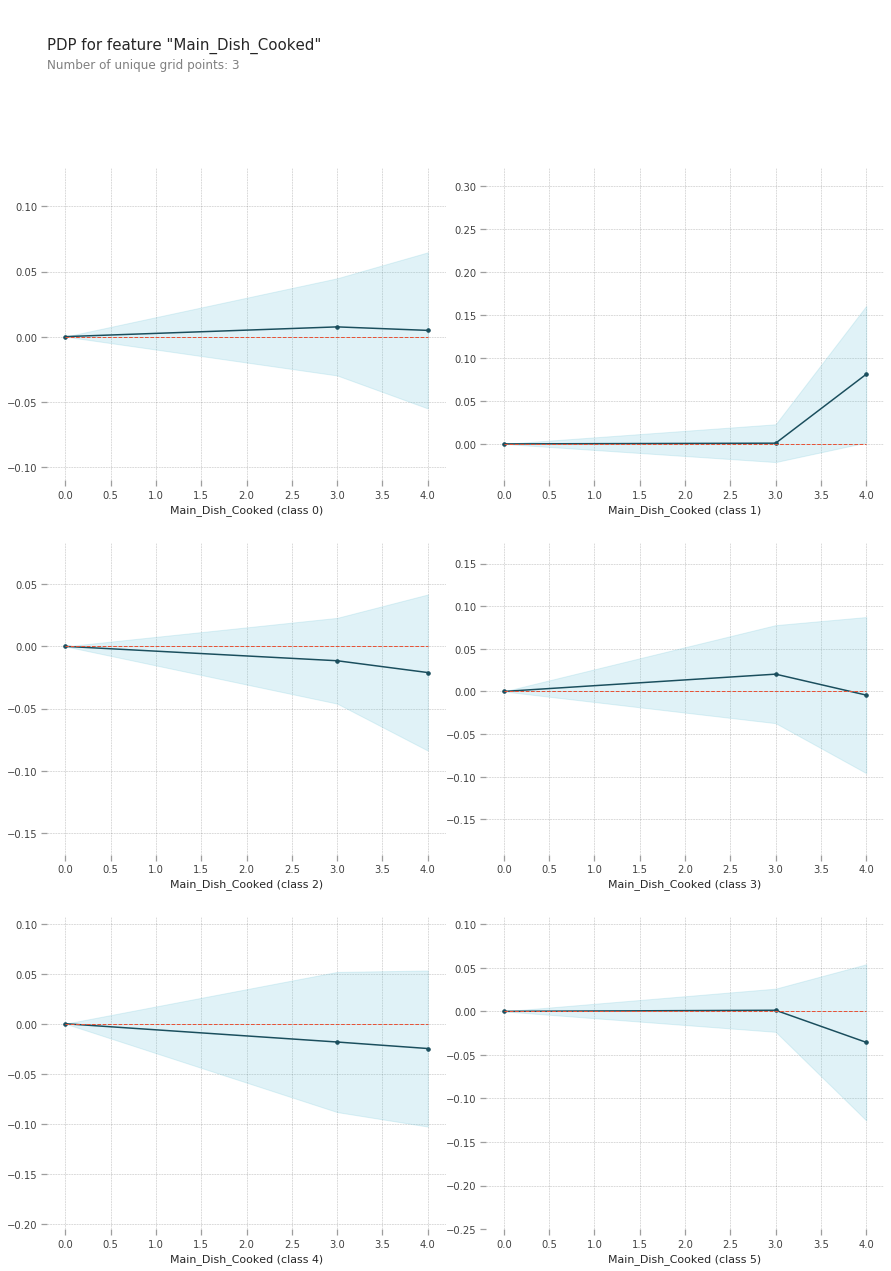

In [15]:
pdp_plot(isolated, feature_name=feature)

(<Figure size 1080x1620 with 7 Axes>,
 {'pdp_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x7fdfba7136a0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fdfba7564e0>})

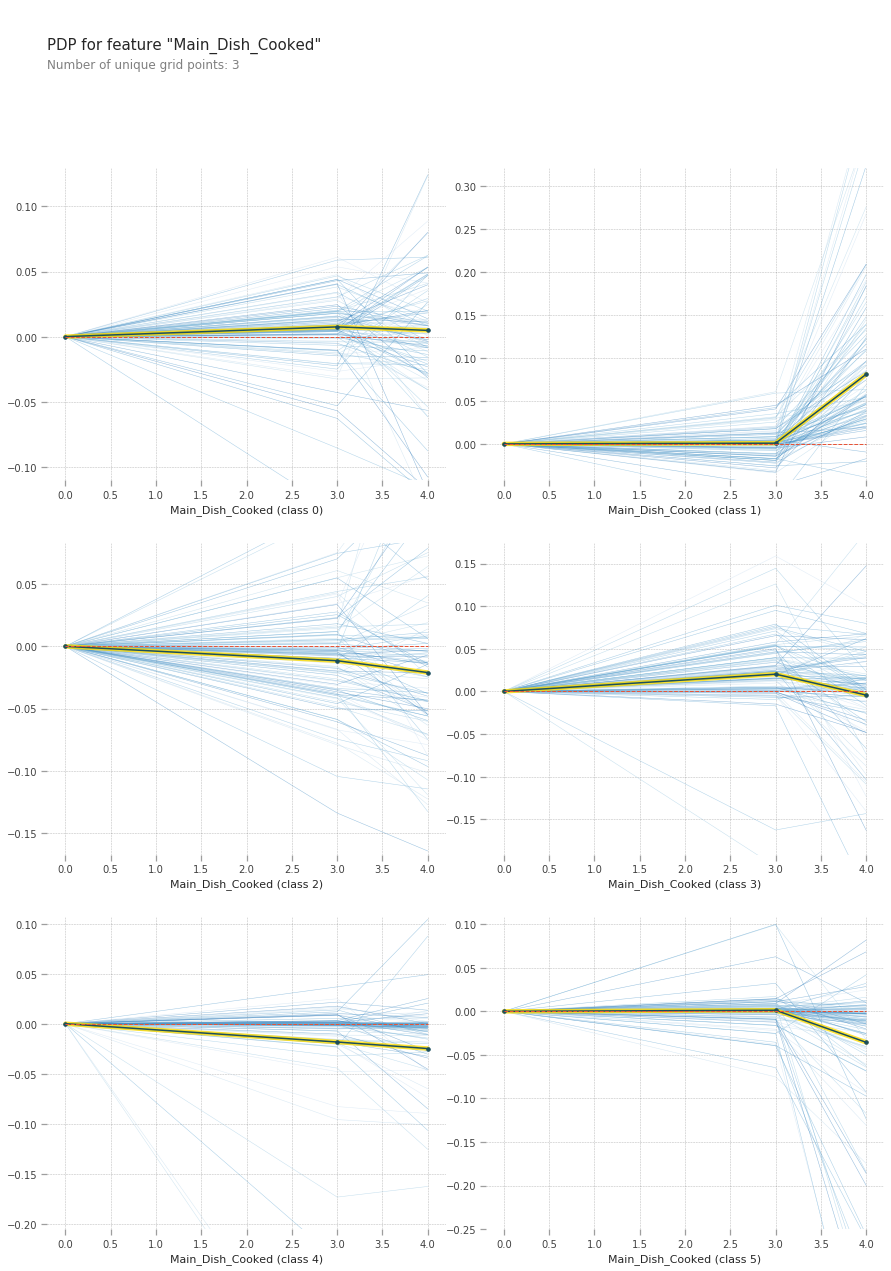

In [16]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100)

#Feature Grids Error

In [17]:
grid = isolated.feature_grids
pdp = isolated.pdp

AttributeError: ignored

In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features=['Main_Dish','Main_Dish_Cooked']

interaction = pdp_interact(
    model=gb,
    dataset=X_train_encoded,
    model_features=X_train_encoded.columns,
    features=features
)

(<Figure size 1080x1764 with 13 Axes>,
 {'pdp_inter_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x7fdd14593ef0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fdd10a76ef0>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


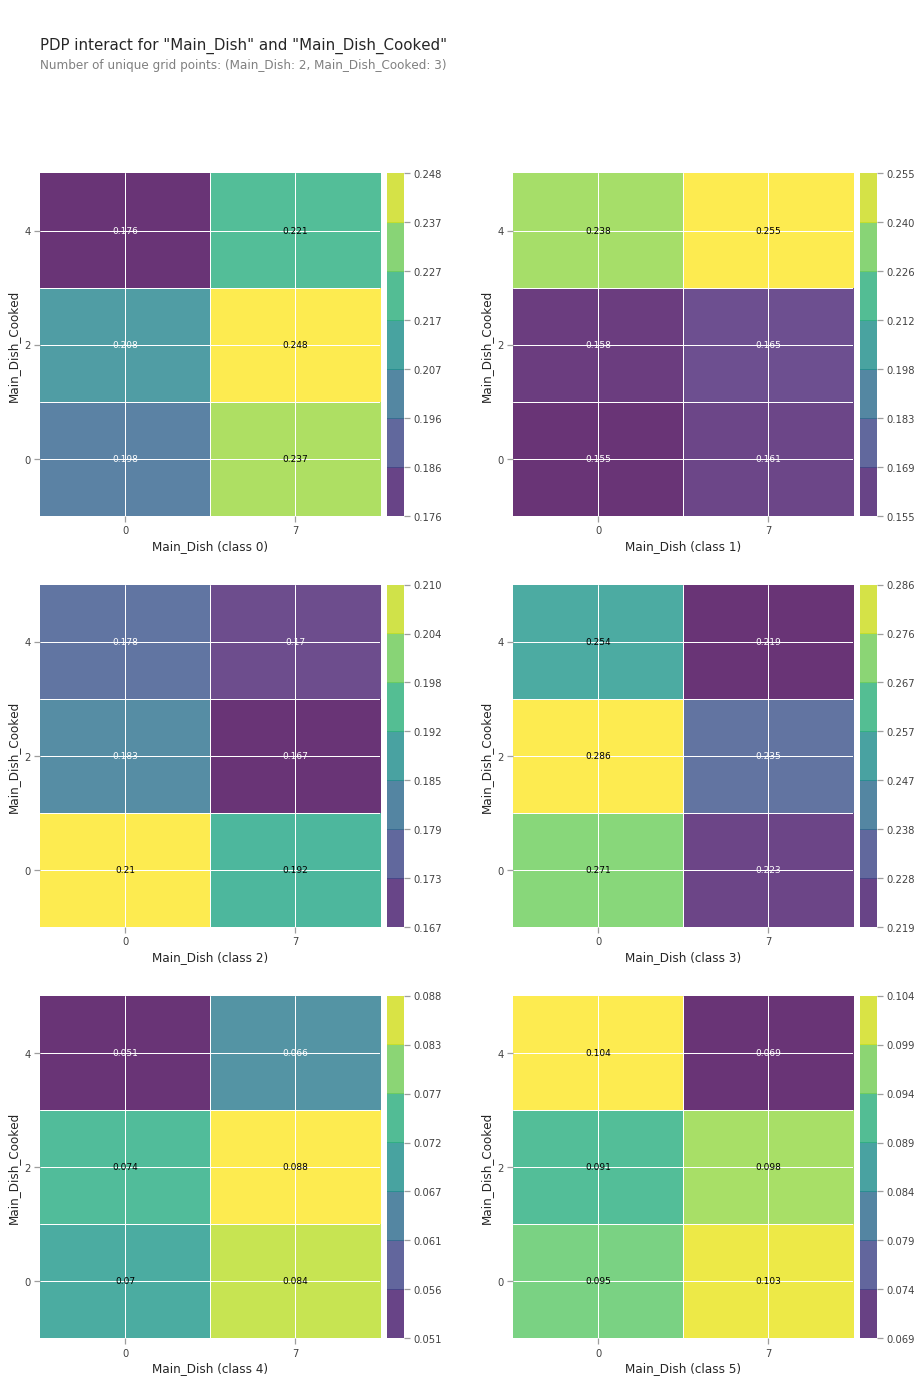

In [135]:
pdp_interact_plot(interaction, plot_type='grid', feature_names=features)

In [19]:
pdp = interaction.pdp.pivot_table(
    values='preds',
    columns=features[0],
    index=features[1]
)

plt.figure(figsize=(10,6))
sns.heatmap(pdp, annot=True, fmt=0)

AttributeError: ignored

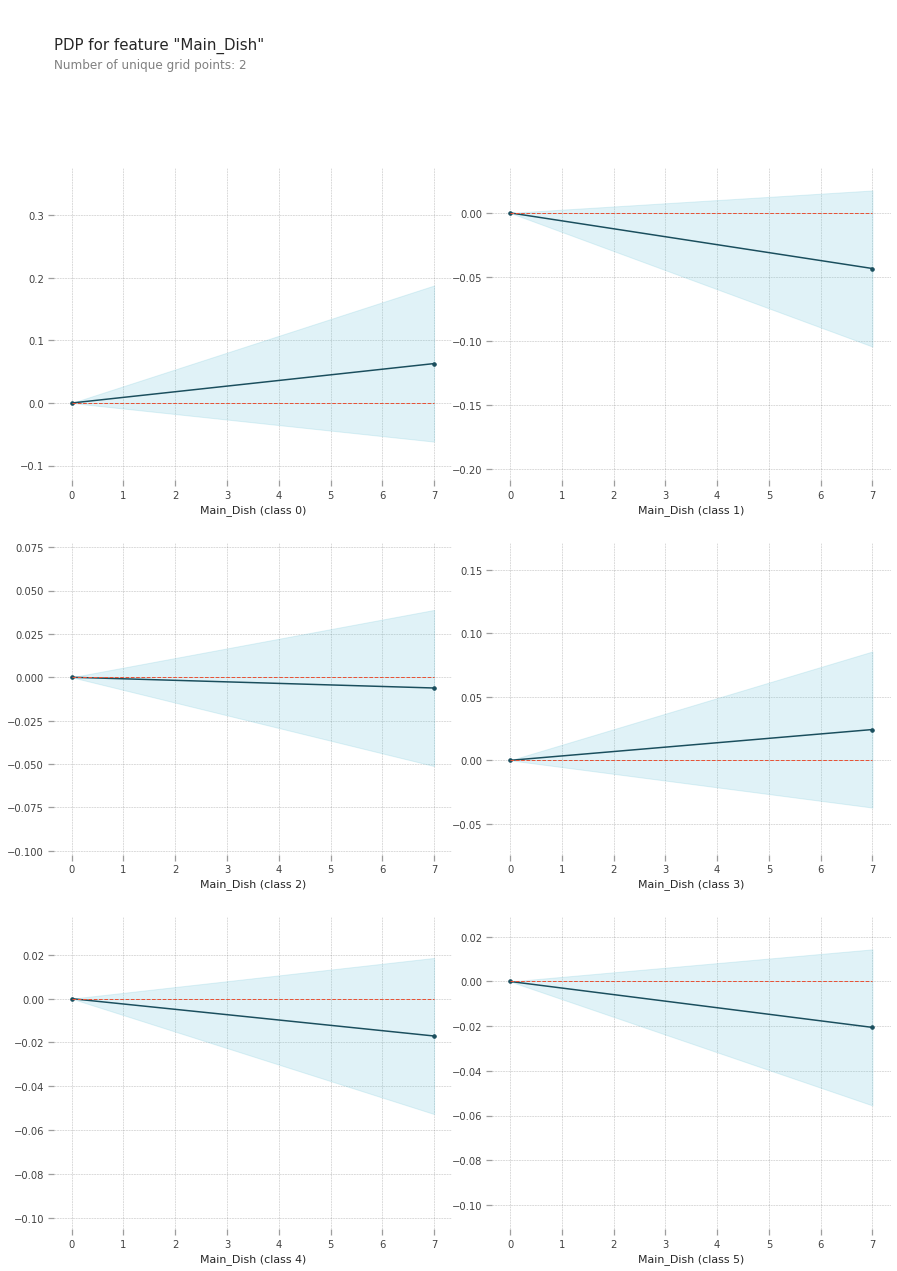

In [24]:
import matplotlib.pyplot as plt
from pdpbox import pdp

pdp_dist = pdp.pdp_isolate(model=gb, dataset=X_train_encoded, 
                           model_features=X_train_encoded.columns, feature='Main_Dish')
pdp.pdp_plot(pdp_dist, 'Main_Dish');

In [30]:
pip install category_encoders as category_encoders

In [0]:
import category_encoders as ce

X_train = train.drop('US_Region', axis=1)

encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)

In [33]:
X_train.isnull().sum()

Main_Dish               0
Main_Dish_Cooked        0
Stuffing                0
Cranberry_Sauce         0
Gravy                   0
Brussel_Sprouts         0
Carrots                 0
Cauliflower             0
Corn                    0
Cornbread               0
Fruit_Salad             0
Green_Beans             0
Mac_and_Cheese          0
Mashed_Potatoes         0
Rolls_Biscuits          0
Squash                  0
Salad                   0
Sweet_Potatoes          0
Apple_Pie               0
Buttermilk_Pie          0
Cherry_Pie              0
Chocolate_Pie           0
Coconut_Cream_Pie       0
Key_Lime_Pie            0
Peach_Pie               0
Pecan_Pie               0
Pumpkin_Pie             0
Sweet_Potato_Pie        0
No_Pie                  0
Apple_Cobbler           0
Blondies                0
Brownies                0
Carrot_Cake             0
Cheesecake              0
Cookies                 0
Fudge                   0
Ice_Cream               0
Peach_Cobbler           0
No_Dessert  

In [51]:
encoder.mapping

[{'col': 'Main_Dish', 'data_type': dtype('O'), 'mapping': Turkey      1
  Chicken     2
  Tofurkey    3
  Ham/Pork    4
  Other       5
  NaN        -2
  dtype: int64},
 {'col': 'Main_Dish_Cooked',
  'data_type': dtype('O'),
  'mapping': Baked                     1
  Roasted                   2
  I don't know              3
  Other (please specify)    4
  Fried                     5
  NaN                      -2
  dtype: int64},
 {'col': 'Stuffing',
  'data_type': dtype('O'),
  'mapping': Other (please specify)    1
  Bread-based               2
  None                      3
  Rice-based                4
  NaN                      -2
  dtype: int64},
 {'col': 'Cranberry_Sauce',
  'data_type': dtype('O'),
  'mapping': Canned                    1
  Homemade                  2
  None                      3
  Other (please specify)    4
  NaN                      -2
  dtype: int64},
 {'col': 'Gravy', 'data_type': dtype('O'), 'mapping': Yes    1
  No     2
  NaN   -2
  dtype: int64},
 {'col

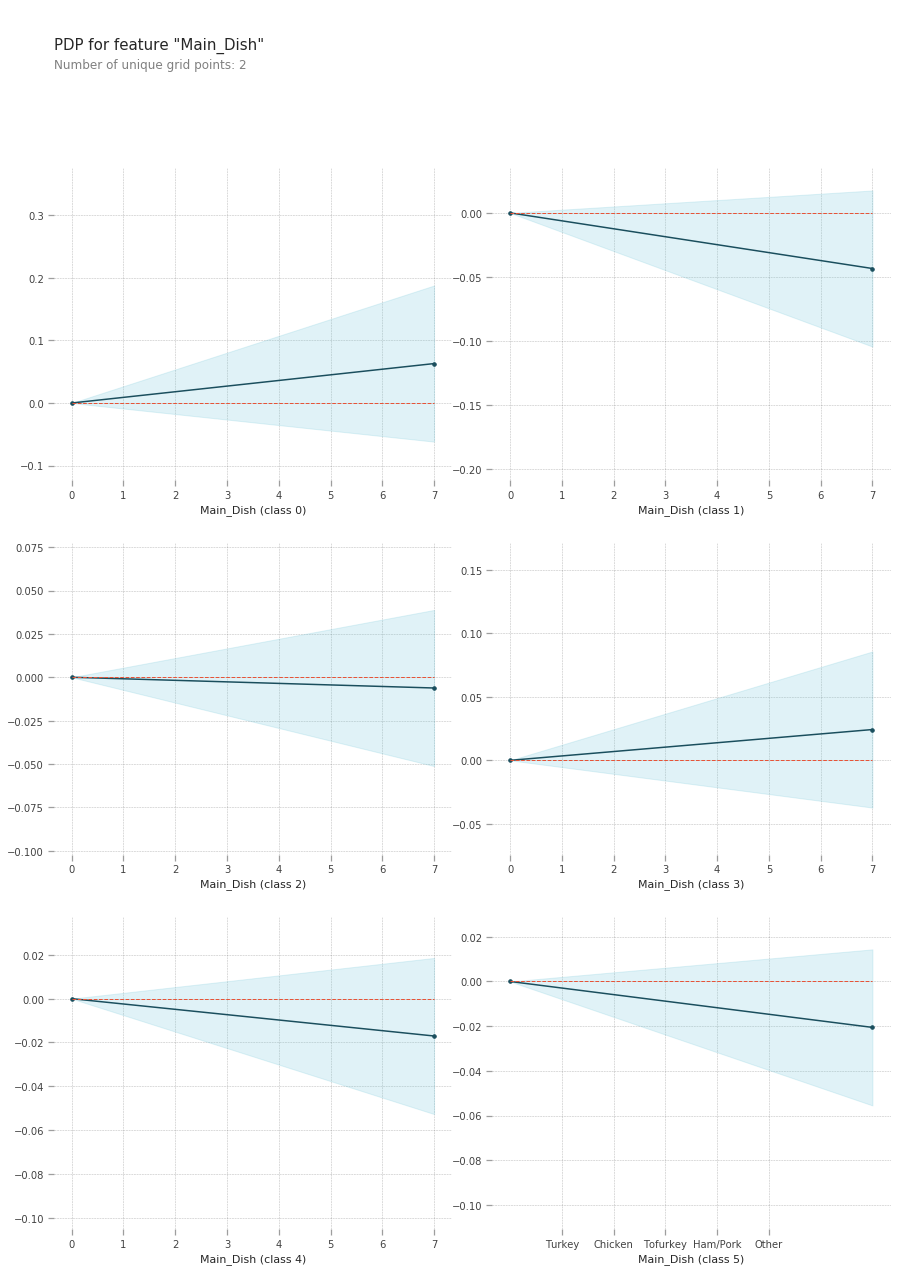

In [53]:
for plot in pdp.pdp_plot(pdp_dist, 'Main_Dish'):
  plt.xticks([1,2,3,4,5], ['Turkey', 'Chicken', 'Tofurkey', 'Ham/Pork','Other'])